# Time Series

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm


In [173]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'

Введем индексацию по дате

In [174]:
train_df = pd.read_csv(TRAIN_PATH, index_col=["Date"], parse_dates=["Date"])
test_df = pd.read_csv(TEST_PATH, index_col=["Date"], parse_dates=["Date"])
train_df.head()

,Store,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010-01-10,1,1453329.50,71.89,2.603,211.671989,7.838
2010-02-04,1,1594968.28,62.27,2.719,210.820450,7.808
2010-02-07,1,1492418.14,80.91,2.669,211.223533,7.787
2010-02-19,1,1611968.17,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,46.63,2.561,211.319643,8.106


Проверим на наличие пропусков и дубликатов

In [175]:
print(train_df.isnull().sum())
print(train_df.duplicated().sum())

Store           0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64
0


# *пиздатый датасет*

In [176]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6255 entries, 2010-01-10 to 2012-10-08
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6255 non-null   int64  
 1   Weekly_Sales  6255 non-null   float64
 2   Temperature   6255 non-null   float64
 3   Fuel_Price    6255 non-null   float64
 4   CPI           6255 non-null   float64
 5   Unemployment  6255 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 342.1 KB


Посмотрим на выбросы таргета в каждом магазине отдельно

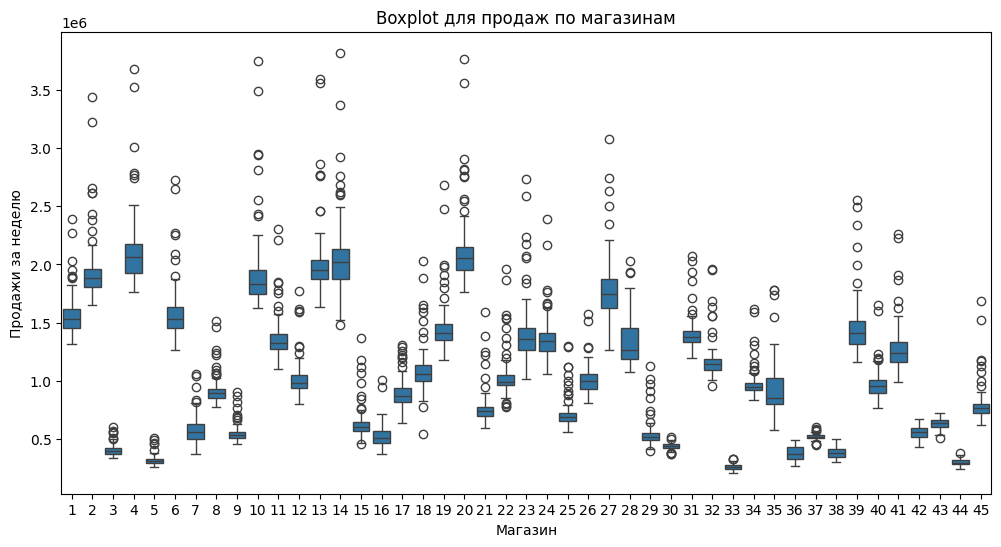

In [177]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='Store', y='Weekly_Sales', data=train_df)
plt.title('Boxplot для продаж по магазинам')
plt.xlabel('Магазин')
plt.ylabel('Продажи за неделю')
plt.show()

Видно, что все магазины имеют выбросы, поэтому их нужно удалить, используя метод IQR(ме)


In [299]:
train_df['Q1'] = train_df.groupby('Store')['Weekly_Sales'].transform(lambda x: x.quantile(0.1))
train_df['Q3'] = train_df.groupby('Store')['Weekly_Sales'].transform(lambda x: x.quantile(0.9))
train_df['IQR'] = train_df['Q3'] - train_df['Q1']

train_df['lower_bound'] = train_df['Q1'] - 1.5 * train_df['IQR']
train_df['upper_bound'] = train_df['Q3'] + 1.5 * train_df['IQR']

train_df = train_df[(train_df['Weekly_Sales'] >= train_df['lower_bound']) & (train_df['Weekly_Sales'] <= train_df['upper_bound'])]

train_df = train_df.drop(columns=['Q1', 'Q3', 'IQR', 'lower_bound', 'upper_bound'])

Проверим, что выбросы удалены

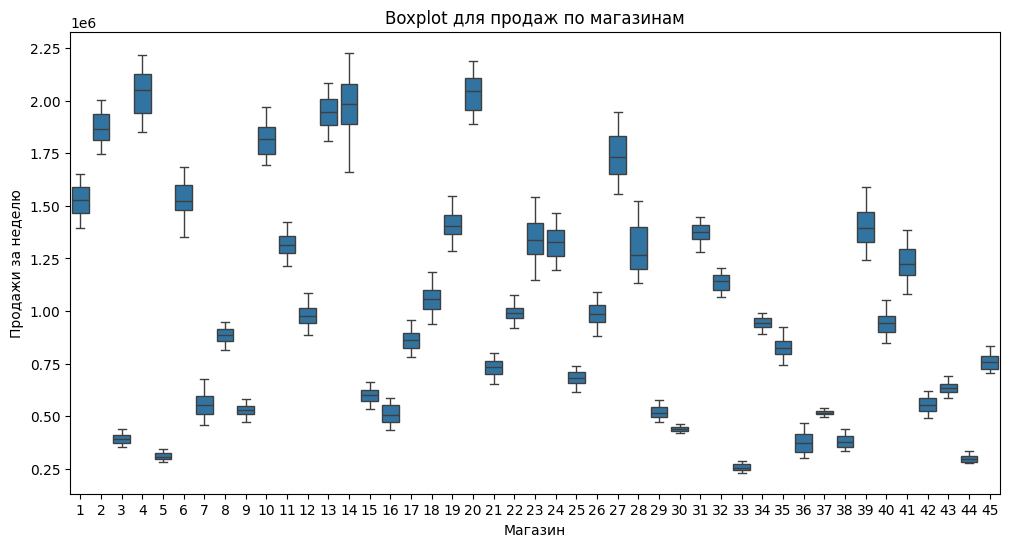

In [300]:

plt.figure(figsize=(12, 6))
sns.boxplot(x='Store', y='Weekly_Sales', data=train_df)
plt.title('Boxplot для продаж по магазинам')
plt.xlabel('Магазин')
plt.ylabel('Продажи за неделю')
plt.show()

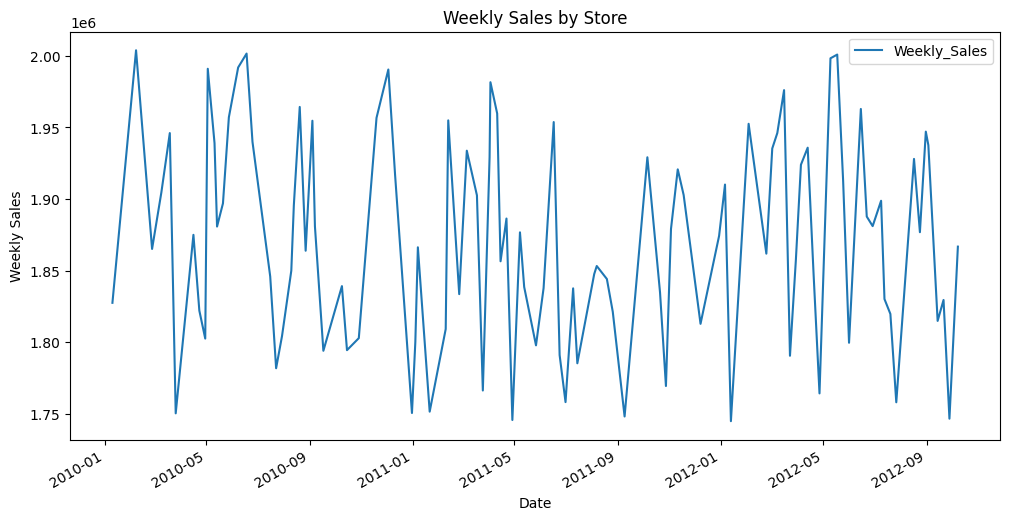

In [301]:
plt.figure(figsize=(12, 6))
train_df[train_df['Store'] == 2]['Weekly_Sales'].plot()
plt.title("Weekly Sales by Store")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.show()

Преобразуем дату

In [302]:
def add_time_features(df):
    df['Weekday'] = df.index.weekday 
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['Week'] = df.index.isocalendar().week 
    return df

train_df = add_time_features(train_df)
test_df = add_time_features(test_df)

Посторим график распределения продаж

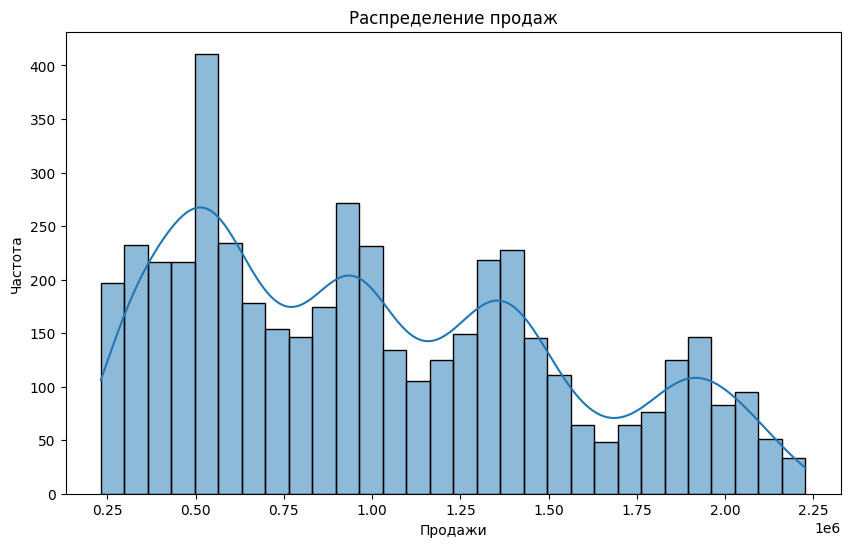

In [304]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df["Weekly_Sales"], bins=30, kde=True)
plt.title("Распределение продаж")
plt.xlabel("Продажи")
plt.ylabel("Частота")
plt.show()

Посмотрим на тренд, сезонность и случайные колебания

<Figure size 1100x900 with 0 Axes>

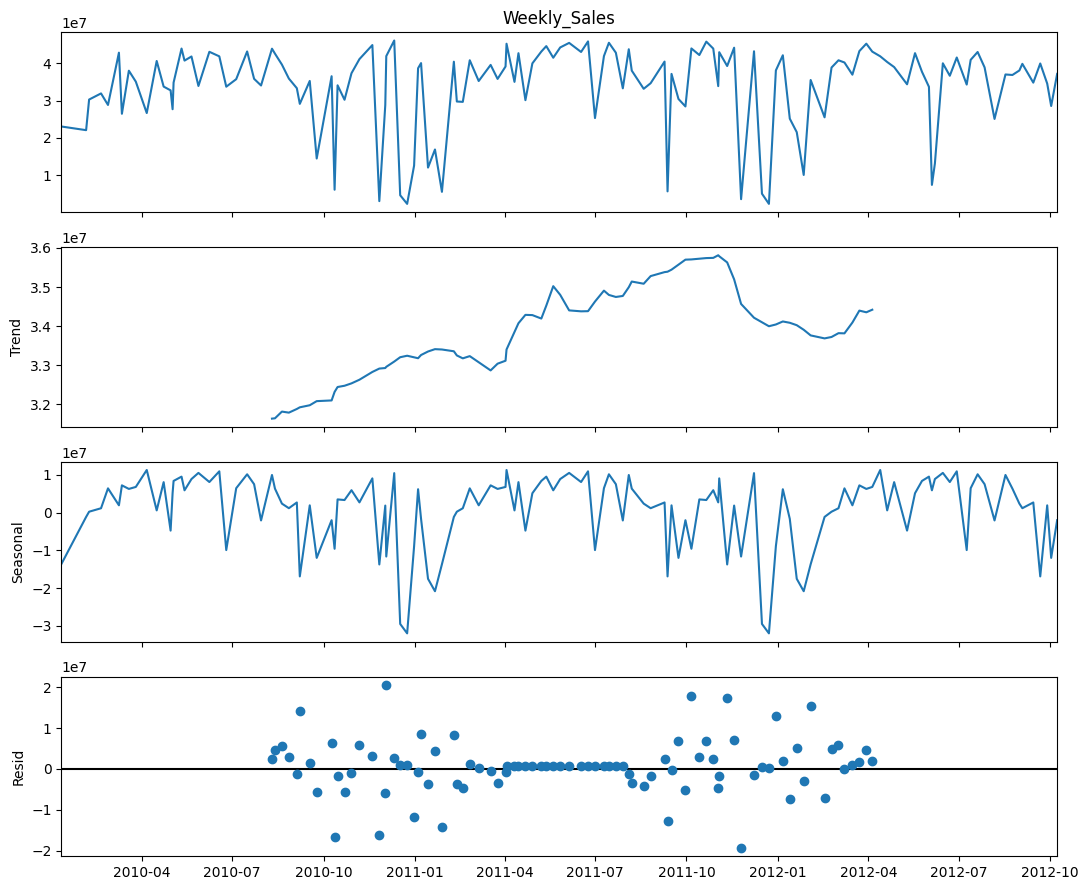

In [315]:
weekly_sales = train_df.groupby('Date')['Weekly_Sales'].sum()

plt.figure(figsize=(11, 9))

decompose = seasonal_decompose(weekly_sales, model='additive', period=52)
decompose.plot()

plt.show()

Тест Дики-Фуллера для оценки стационарности

In [307]:
grouped = train_df.groupby('Store')

def adf_test(series):
    result = adfuller(series)
    return result[1]

adf_results = grouped['Weekly_Sales'].apply(adf_test)

non_stationary_stores = adf_results[adf_results > 0.05]

print(non_stationary_stores)

Store
3     0.129301
4     0.828168
14    0.336178
31    0.481603
33    0.239911
35    0.115165
36    0.697066
38    0.881380
39    0.714000
44    0.944476
Name: Weekly_Sales, dtype: float64


Итого получаем, критерий Дики-Фуллера не отвергает гипотезу нестационарности для магазинов 3, 4, 14, 31, 33, 35, 36, 38, 39 и 43

Сделаем дифференцирование для данных и проверим еще раз на наличие нестационарности

In [308]:
def differentiate_with_shift_inplace(df, shift=1):
    df['Diff_Weekly_Sales'] = df.groupby('Store')['Weekly_Sales'].transform(lambda x: x - x.shift(shift))

differentiate_with_shift_inplace(train_df, shift=1)

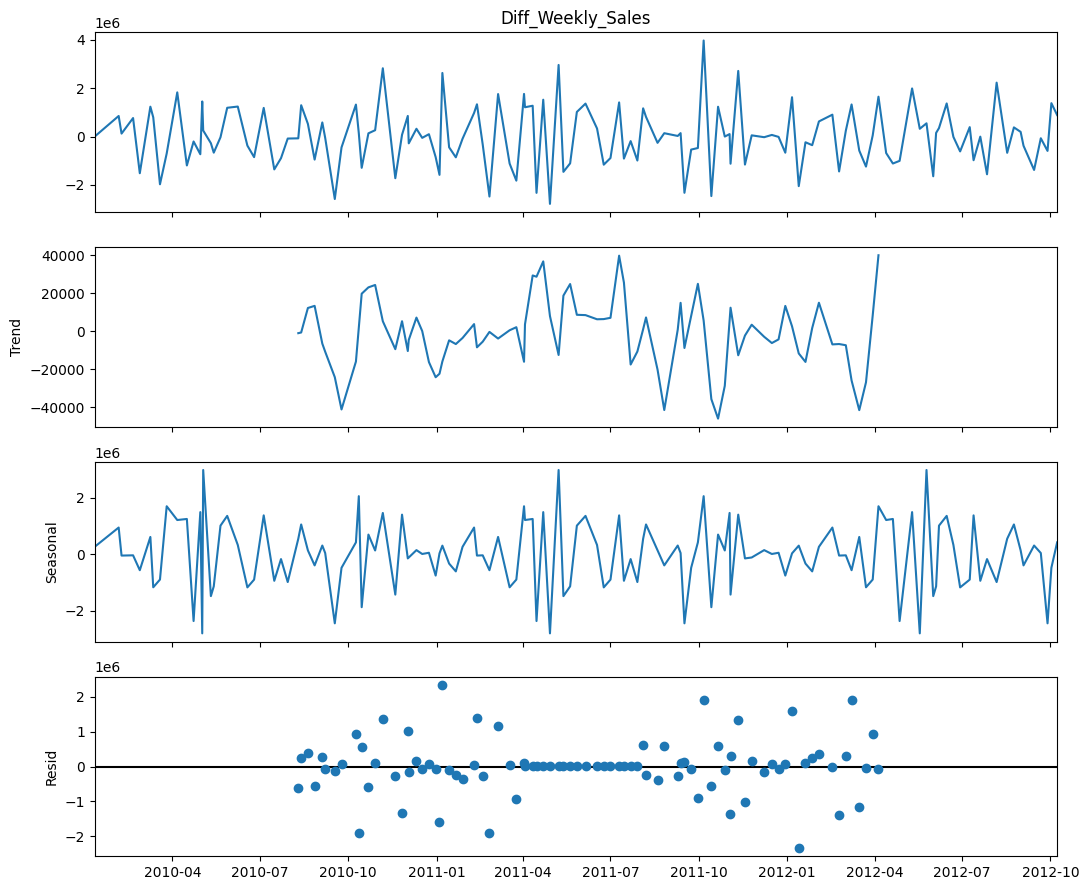

Series([], Name: Diff_Weekly_Sales, dtype: float64)


In [309]:
weekly_sales = train_df.groupby('Date')['Diff_Weekly_Sales'].apply(lambda x: x.iloc[1:].sum())
plt.figure(figsize=(11, 9))  

decompose = seasonal_decompose(weekly_sales, model='additive', period=52)
decompose.plot()

plt.show()

grouped = train_df.groupby('Store')

def adf_test(series):
    result = adfuller(series)
    return result[1]

adf_results = grouped['Diff_Weekly_Sales'].apply(lambda x: adf_test(x[1:]))

non_stationary_stores = adf_results[adf_results > 0.05]

print(non_stationary_stores)

In [310]:
grouped = train_df.groupby('Store')

def adf_test(series):
    result = adfuller(series)
    return result[1]

adf_results = grouped['Diff_Weekly_Sales'].apply(lambda x: adf_test(x[1:]))

non_stationary_stores = adf_results[adf_results > 0.05]

print(non_stationary_stores)

Series([], Name: Diff_Weekly_Sales, dtype: float64)


In [296]:
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Weekday', 'Month', 'Year', 'Week']

all_y_true = []
all_y_pred = []
models = {} 

for store_id in train_df['Store'].unique():

    store_data = train_df[train_df['Store'] == store_id]
    
    X = store_data[features]
    y = store_data['Weekly_Sales']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = ElasticNet(
    alpha=0.01,

    l1_ratio=0.1,
    fit_intercept=True,

    max_iter=100,
    tol=1e-4,
    precompute=True,

    warm_start=False,

    positive=False
    )
    model.fit(X_train, y_train)
    
    models[store_id] = model
    
    y_pred = model.predict(X_test)


    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

print("MAPE: ", mean_absolute_percentage_error(all_y_true, all_y_pred))


MAPE:  0.03903809179211028


/Users/admin/Desktop/MAI/Third/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141863652898.71204, tolerance: 43683249.0198648
  model = cd_fast.enet_coordinate_descent_gram(
/Users/admin/Desktop/MAI/Third/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 159456905751.44662, tolerance: 42280620.30369031
  model = cd_fast.enet_coordinate_descent_gram(
/Users/admin/Desktop/MAI/Third/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12802368670.736206, tolerance: 4396005.017612271
  model = cd_fast.enet_coordinate_descent_gram(
/Users/admin/Desktop/MA

# Submit

In [297]:
predictions = []

for store_id, store_data in test_df.groupby('Store'):
    model = models.get(store_id)
    
    X_test = store_data[features]
    
    y_pred = model.predict(X_test)
    
    predictions.extend(y_pred)

data = {
    "source_attractiveness": predictions
}
submit = pd.DataFrame(data)
submit.to_csv('submission.csv', index_label="ID")